# Fraud Detection with XGBoost and Machine Learning in DSX Local
<a id='toc'></a>

The purpose of this notebook:
1. Showcase how to build and deploy a XGBoost Model in DSX Local.
2. Share our experiences with XGB and SMOTE. The project originates from a SPSS Modeler stream with which we wanted to showcase how coders and non-coders could work together in DSX environment. But we saw different output with same data and 'same' settings(as we assumed, but there are some 'bugs' we did not notice at first, we will cover it later in the notebook).

Note: The data is simulated for demo purpose only.


1. [Imports](#Imports)
2. [Load Data](#Load Data)
3. [Exploratory Data Analysis](#eda)
4. [Split into Training and Test](#Split into Training and Test)
5. [Handle Imbalance using SMOTE(only on Training set)](#Handle Imbalance using SMOTE)
6. [XGboost](#xgboost)  
    6.1 [Build Pipeline](#ppl)  
    6.2 [Plot Feature Importance](#imp)  
    6.3 [Model Evaluation](#eva)      
7. [Model Deployment using DSX Machine Learning](#deploy)  
    7.1 [Online Scoring](#online)  
    7.2 [Batch Scoring](#batch)  

<a id='Imports'></a>
## Imports
<div style="text-align: right"> [Top](#toc) </div>

In [249]:
import xgboost as xgb
print(xgboost.__version__)

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn_pandas import DataFrameMapper

import brunel
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

0.7.post3


<a id='Load Data'></a>
## Load Data
<div style="text-align: right"> [Top](#toc) </div>

In [240]:
# The code was removed by DSX for sharing.

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Fraudulent,Last3hourTransactions,Hours_Since_Last_Transaction
0,188.56,swiped,ATM Withdrawal,E,USA,F,4,21
1,160.54,keyed,Grocery,NE,Australia,F,3,21
2,153.24,swiped,Retail - Pharmacy,SW,European Union,T,2,21
3,148.66,keyed,Communications - telephone and wireless,NW,USA,F,1,35
4,174.03,keyed,Spa/Beauty,SW,Asia,F,1,25


In [8]:
import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/History_Transactions_v4.csv')
# only keep variables we will use later
df_data_1 = df_data_1[['Dollar_Amount', 
                       'Transaction_Type',
                       'Store_Type', 
                       'Cardholder_Region', 
                       'Country',
                       'Fraudulent',
                       'Last3hourTransactions',
                       'Hours_Since_Last_Transaction'
                      ]]
df_data_1.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Fraudulent,Last3hourTransactions,Hours_Since_Last_Transaction
0,188.56,swiped,ATM Withdrawal,E,USA,F,4,21
1,160.54,keyed,Grocery,NE,Australia,F,3,21
2,153.24,swiped,Retail - Pharmacy,SW,European Union,T,2,21
3,148.66,keyed,Communications - telephone and wireless,NW,USA,F,1,35
4,174.03,keyed,Spa/Beauty,SW,Asia,F,1,25


<a id='eda'></a>
## Exploratory Data Analysis
<div style="text-align: right"> [Top](#toc) </div>

The data is actually well cleaned so we will just focus on the SMOTE and XGB, and keep data prep and EDA to minimal.

In [3]:
# check missing
df_data_1.apply(lambda x: sum(x.isnull()))

Dollar_Amount                   0
Transaction_Type                0
Store_Type                      0
Cardholder_Region               0
Country                         0
Fraudulent                      0
Last3hourTransactions           0
Hours_Since_Last_Transaction    0
dtype: int64

In [4]:
# Look at categorical variables
var = ['Fraudulent', 'Transaction_Type', 'Store_Type', 'Cardholder_Region', 'Country']
for v in var:
    print("****************************************")
    print('\nFrequency count for variable %s'%v)
    print(df_data_1[v].value_counts())

****************************************

Frequency count for variable Fraudulent
F    52132
T     2903
Name: Fraudulent, dtype: int64
****************************************

Frequency count for variable Transaction_Type
swiped    27623
keyed     27412
Name: Transaction_Type, dtype: int64
****************************************

Frequency count for variable Store_Type
Restaurant                                 4470
Professional Services                      3443
Grocery                                    3403
Gas                                        3261
Other                                      3226
Hotel                                      3206
Retail - Apparel                           2276
ATM Withdrawal                             2240
Retail - Furniture                         2232
Entertainment and Arts                     2207
Retail - Home Improvement                  2194
Retail - Drug Store                        2193
Communications - telephone and wireless    2191
Me

## Split into Training and Test

In [241]:
y = df_data_1['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X = df_data_1.drop(['Fraudulent'], axis=1)

from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)

print("Number of training records: " + str(len(X_train)))
print("Training: T = : " + str(sum(y_train)))
print("Training: F = : " + str(len(X_train) - sum(y_train)))
print("Number of testing records : " + str(len(X_test)))
print("Testing: T = : " + str(sum(y_test)))
print("Testing: F = : " + str(len(X_test) - sum(y_test)))

Number of training records: 44028
Training: T = : 2304
Training: F = : 41724
Number of testing records : 11007
Testing: T = : 599
Testing: F = : 10408


The data is imbalanced. We used SMOTE to handle the imbalance. 

## Handle Imbalance using SMOTE(only on Training set)

In [12]:
!pip install imblearn

    100% |████████████████████████████████| 153kB 995kB/s eta 0:00:01


In [242]:
# restart kernel if see error
from imblearn.over_sampling import SMOTE

In [243]:
X_train_dummy = pd.get_dummies(X_train)
sm = SMOTE(random_state=2662761, ratio = 'auto', k_neighbors = 5)
X_train_res, y_train_res = sm.fit_sample(X_train_dummy, y_train)
#smote only deals with continuous variable
X_train_res_rounded = X_train_res.round()


print('Fraud/Non-Fraud Ratio Before SMOTE: ' + str(y_train.sum()/len(y_train)))
print('Fraud/Non-Fraud Ratio After SMOTE: ' + str(y_train_res.sum()/len(y_train_res)))

print("Fraud in Training after SMOTE = T: " + str(sum(y_train_res)))
print("Fraud in Training after SMOTE = F: " + str(len(y_train_res) - sum(y_train_res)))
print("\n************Test Set************\n")
print("Number of testing records : " + str(len(X_test)))
print("Training: T = : " + str(sum(y_test)))
print("Training: F = :" + str(len(y_test) - sum(y_test)))

Fraud/Non-Fraud Ratio Before SMOTE: 0.05233033524121014
Fraud/Non-Fraud Ratio After SMOTE: 0.5
Fraud in Training after SMOTE = T: 41724
Fraud in Training after SMOTE = F: 41724

************Test Set************

Number of testing records : 11007
Training: T = : 599
Training: F = :10408


** Important Note: currently SMOTE from imblearn only supports continuous variable, we rounded generated values to 0/1 for binary variables as a walk-around. See discussions [here](https://github.com/scikit-learn-contrib/imbalanced-learn/issues/401). This is the root cause for the difference between Modeler and Notebook, although we are not sure if Modeler has adopted more sophisticated solution to handle categorical variables. ** 

In [244]:
# currently SMOTE from imblearn only supports continuous variable only, round generated value to 0/1 for binary variables as a walkaround
for i in range(len(X_train_res)):
    X_train_res[i][1:] = X_train_res[i][1:].round()

In [246]:
# in order to build pipeline, we need to reverse the matrix returned by SMOTE to df
X_train_df = pd.DataFrame(X_train_res)
X_train_df.columns = pd.get_dummies(X_train).columns.tolist()

X_train_df['Transaction_Type'] = X_train_df[['Transaction_Type_keyed', 'Transaction_Type_swiped']].idxmax(axis=1).map(lambda l: l.replace('Transaction_Type_', ''))
X_train_df['Store_Type'] = X_train_df[['Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail']].idxmax(axis=1).map(lambda l: l.replace('Store_Type_', ''))

X_train_df['Country'] = X_train_df[['Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA']].idxmax(axis=1).map(lambda l: l.replace('Country_', ''))

X_train_df['Cardholder_Region'] = X_train_df[['Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W']].idxmax(axis=1).map(lambda l: l.replace('Cardholder_Region_', ''))

X_train_df = X_train_df.drop(['Transaction_Type_keyed', 'Transaction_Type_swiped', 'Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail', 'Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA', 'Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W'], 1)

## XGboost

### Baseline: Default Setting from Modeler

Let's start with the default parameters from Modeler.

In [250]:
mapper1 = DataFrameMapper(
    [(['Dollar_Amount'], None),
     (['Last3hourTransactions'], None),
     (['Hours_Since_Last_Transaction'], None),
     ('Transaction_Type', LabelBinarizer()), # for binary, only one variable generated
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

In [253]:
X_train_res_maptrsfm = mapper1.fit_transform(X_train_df)
X_test_maptrsfm = mapper1.fit_transform(X_test)

In [255]:
xgb_model_spss = XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, 
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)

In [256]:
xgb_model_spss.fit(X_train_res_maptrsfm, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=1.0, gamma=0.0, learning_rate=0.3,
       max_delta_step=0.0, max_depth=6, min_child_weight=1.0, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.0,
       reg_lambda=1.0, scale_pos_weight=1.0, seed=6924827, silent=True,
       subsample=1.0, tree_method='auto')

In [257]:
pred_spss = xgb_model_spss.predict(X_test_maptrsfm)

In [258]:
roc_spss = roc_auc_score(y_test, pred_spss)
print("*****Confusion Matrix *****")
print(confusion_matrix(y_test, pred_spss))
print("*****Classification Report*****")
print(classification_report(y_test, pred_spss))
print("ROC: " +  str(roc_spss))

*****Confusion Matrix *****
[[6726 3682]
 [ 244  355]]
*****Classification Report*****
             precision    recall  f1-score   support

          0       0.96      0.65      0.77     10408
          1       0.09      0.59      0.15       599

avg / total       0.92      0.64      0.74     11007

ROC: 0.6194440452252601


In [292]:
def evaluate_it(alg):
    alg.fit(X_train_res_maptrsfm, y_train_res)
    pred = alg.predict(X_test_maptrsfm)
    roc = roc_auc_score(y_test, pred)
    print("*****Confusion Matrix *****")
    print(confusion_matrix(y_test, pred))
    print("*****Classification Report*****")
    print(classification_report(y_test, pred))
    print("ROC: " +  str(roc))

    

### Plot Feature Importance

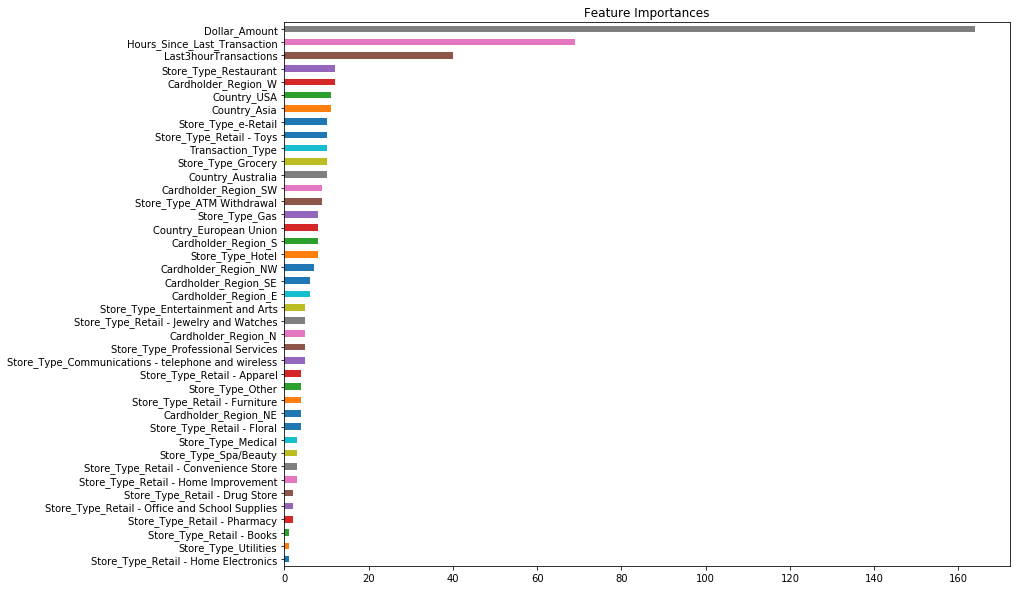

In [272]:
fig, axs = plt.subplots(nrows= 1, figsize=(13, 10))
feat_imp = pd.Series(xgb_model_spss._Booster.get_fscore()).sort_values()
X_train_dummy_names  =  mapper1.fit(X_train_df).transformed_names_

x=[]
for i in range(0, len(X_train_dummy_names)):
    x.append( "f"+ str(i))

feat_imp_reindex = feat_imp.rename(lambda y: dict(zip(x, X_train_dummy_names))[y])
feat_imp_reindex.plot(kind='barh', title='Feature Importances')

## Hyperparameter Tuning

Lets try tuning hyperpafameters and see if we could further boost model performance. 

1. Start with the default values from SPSS Modeler  
2. Fix learning rate and search for the optimum number of trees by training with early_stopping_rounds configured
3. Use RandomizedSearchCV to search on hyper parameters.

You can try brute-force grid search but it's gonna take a long time. That's why we want to be a little bit conservative on how to search for optimal parameters. Even small improvement would be good enough to give you the idea.

### Set learning_rate and n_estimators

In [280]:
xgb_model_1 = XGBClassifier(
    tree_method= "auto",
    n_estimators = 1000, # start with a large value
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .1, # lower it
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)

In [281]:
xgtrain = xgb.DMatrix(X_train_res_maptrsfm, label=y_train_res)
xgb_param = xgb_model_1.get_xgb_params()
xgb_param['eval_metric'] = 'auc'
dtest = xgb.DMatrix(mapper1.fit_transform(X_test), label = y_test)

model = xgb.train(
    xgb_param,
    xgtrain,
    evals=[(xgtrain, "Train"),(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Train-auc:0.699632	Test-auc:0.65423
Multiple eval metrics have been passed: 'Test-auc' will be used for early stopping.

Will train until Test-auc hasn't improved in 10 rounds.
[1]	Train-auc:0.707122	Test-auc:0.648356
[2]	Train-auc:0.715468	Test-auc:0.652281
[3]	Train-auc:0.71773	Test-auc:0.655368
[4]	Train-auc:0.720271	Test-auc:0.656795
[5]	Train-auc:0.722457	Test-auc:0.65844
[6]	Train-auc:0.725514	Test-auc:0.657708
[7]	Train-auc:0.72751	Test-auc:0.661627
[8]	Train-auc:0.729337	Test-auc:0.661908
[9]	Train-auc:0.731244	Test-auc:0.663043


In [290]:
print("Best AUC: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best AUC: 0.66 with 10 rounds


In [291]:
xgb_model_1 = XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, # reset to
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .1, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)

In [293]:
evaluate_it(xgb_model_1)

*****Confusion Matrix *****
[[6952 3456]
 [ 255  344]]
*****Classification Report*****
             precision    recall  f1-score   support

          0       0.96      0.67      0.79     10408
          1       0.09      0.57      0.16       599

avg / total       0.92      0.66      0.75     11007

ROC: 0.6211191083268424


By lowering the learning rate, roc increased. Move forward with learning_rate = .1, and n_estimators = 10

### Use RandomizedSearchCV to search on hyperparameters.

You can add more parameters and more options if you want to be very thorough. But here my goal is to get a quick output.

### Build Pipeline

In [182]:
mapper1 = DataFrameMapper(
    [(['Dollar_Amount'], None),
     (['Last3hourTransactions'], None),
     (['Hours_Since_Last_Transaction'], None),
     ('Transaction_Type', LabelBinarizer()), # for binary, only one variable generated
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

In [183]:
# build pipeline
pipeline = Pipeline([('mapper', mapper1), ('classifier', XGBClassifier(tree_method= "auto",
    n_estimators = ,
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .2,
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0))])

In [187]:
pipeline = Pipeline([('mapper', mapper1), ('classifier', XGBClassifier(
    tree_method= "auto",
    n_estimators = 10, 
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    learning_rate = .01, # fixed
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0,
    gamma = 0.5,
    colsample_bytree = 0.6,
    subsample = .8,
    min_child_weight = 1.0,
    max_depth = 6))])

In [188]:
# fit ppl
pipeline.fit(X_train_df, y_train_res)

Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['Dollar_Amount'], None), (['Last3hourTransactions'], None), (['Hours_Since_Last_Transaction'], None), ('Transaction_Type', LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)), ('Store_Type', LabelBinarizer(...da=1.0, scale_pos_weight=1.0, seed=6924827, silent=True,
       subsample=0.8, tree_method='auto'))])

### Model Evaluation

In [189]:
pred_classifier = pipeline.predict(X_test)

/gpfs/fs01/user/s34f-24c5585e483e16-c0ce2641d0ef/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [190]:
roc = roc_auc_score(y_test, pred_classifier)
print("*****Confusion Matrix *****")
print(confusion_matrix(y_test, pred_classifier))
print("*****Classification Report*****")
print(classification_report(y_test, pred_classifier))
print("ROC: " +  str(roc))

*****Confusion Matrix *****
[[7002 3406]
 [ 255  344]]
*****Classification Report*****
             precision    recall  f1-score   support

          0       0.96      0.67      0.79     10408
          1       0.09      0.57      0.16       599

avg / total       0.92      0.67      0.76     11007

ROC: 0.6235211067895634


## Hyperparameter Tuning

Lets try tuning hyperpafameters and see if we could further boost model performance. In order to make it clear, we will get rid of pipleline for now. Here is the strategy:

1. Start with the default values from SPSS Modeler  
2. Fix learning rate at .1 and search for the optimum number of trees by training with early_stopping_rounds configured
3. Use RandomizedSearchCV to search on hyper parameters.

You can try brute-force grid search but it's gonna take a long time. That's why we want to be a little bit conservative on how to search for optimal parameters. Even small improvement would be good enough to give you the idea.

In [124]:
xgb_model = XGBClassifier(
    tree_method= "auto",
    n_estimators = 1000, # start with a large value
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .1, # fixed
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)

In [211]:
X_train_res = mapper1.fit_transform(X_train_df)

In [229]:
xgtrain = xgb.DMatrix(X_train_res, label=y_train_res)
xgb_param = xgb_model.get_xgb_params()
xgb_param['eval_metric'] = 'auc'
dtest = xgb.DMatrix(mapper1.fit_transform(X_test), label = y_test)

model = xgb.train(
    xgb_param,
    xgtrain,
    evals=[(xgtrain, "Train"),(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Train-auc:0.696744	Test-auc:0.654399
Multiple eval metrics have been passed: 'Test-auc' will be used for early stopping.

Will train until Test-auc hasn't improved in 10 rounds.
[1]	Train-auc:0.709144	Test-auc:0.657518
[2]	Train-auc:0.713448	Test-auc:0.658664
[3]	Train-auc:0.713423	Test-auc:0.660792
[4]	Train-auc:0.721051	Test-auc:0.665305
[5]	Train-auc:0.720711	Test-auc:0.664873
[6]	Train-auc:0.722232	Test-auc:0.665524
[7]	Train-auc:0.724308	Test-auc:0.666046
[8]	Train-auc:0.723701	Test-auc:0.666994
[9]	Train-auc:0.72525	Test-auc:0.666754


In [ ]:
{'gamma': 2, 'colsample_bytree': 1.0, 'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6}

In [230]:
print("Best AUC: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best AUC: 0.67 with 9 rounds


In [ ]:
{'gamma': 0, 'colsample_bytree': 0.8, 'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6}

In [223]:
xgb_model = XGBClassifier(
    tree_method= "auto",
    n_estimators = 6, # reset n_estimators = 6
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = .8,
    learning_rate = .1, # fixed
    gamma = 0.0,
    colsample_bytree = .8,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0)


xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0.0, max_depth=6, min_child_weight=1.0, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1.0,
       seed=6924827, silent=True, subsample=0.8, tree_method='auto')

In [224]:
pred_6rounds = xgb_model.predict(mapper1.fit_transform(X_test))

/gpfs/fs01/user/s34f-24c5585e483e16-c0ce2641d0ef/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [225]:
roc_auc_score(y_test, pred_6rounds)

0.6275747498713586

### 3. Use RandomizedSearchCV to search on hyperparameters.

You can add more parameters and more options if you want to be very thorough. But here my goal is to get a quick output.

In [219]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }

In [220]:
folds = 3

# increase param_comb if you want to run through more candiates
param_comb = 50

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='roc_auc', cv=skf.split(X_train_res, y_train_res), verbose=3, random_state=1001 )

In [221]:
random_search.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] gamma=0.5, colsample_bytree=0.8, subsample=0.6, min_child_weight=10, max_depth=3 
[CV]  gamma=0.5, colsample_bytree=0.8, subsample=0.6, min_child_weight=10, max_depth=3, score=0.6805438693062402, total=   0.5s
[CV] gamma=0.5, colsample_bytree=0.8, subsample=0.6, min_child_weight=10, max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gamma=0.5, colsample_bytree=0.8, subsample=0.6, min_child_weight=10, max_depth=3, score=0.681443617447793, total=   0.5s
[CV] gamma=0.5, colsample_bytree=0.8, subsample=0.6, min_child_weight=10, max_depth=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  gamma=0.5, colsample_bytree=0.8, subsample=0.6, min_child_weight=10, max_depth=3, score=0.6884851474569439, total=   0.5s
[CV] gamma=2, colsample_bytree=1.0, subsample=0.8, min_child_weight=10, max_depth=5 
[CV]  gamma=2, colsample_bytree=1.0, subsample=0.8, min_child_weight=10, max_depth=5, score=0.7033261516019359, total=   0.8s
[CV] gamma=2, colsample_bytree=1.0, subsample=0.8, min_child_weight=10, max_depth=5 
[CV]  gamma=2, colsample_bytree=1.0, subsample=0.8, min_child_weight=10, max_depth=5, score=0.6994220266976487, total=   0.8s
[CV] gamma=2, colsample_bytree=1.0, subsample=0.8, min_child_weight=10, max_depth=5 
[CV]  gamma=2, colsample_bytree=1.0, subsample=0.8, min_child_weight=10, max_depth=5, score=0.7055599700162016, total=   0.8s
[CV] gamma=0, colsample_bytree=1.0, subsample=1.0, min_child_weight=5, max_depth=6 
[CV]  gamma=0, colsample_bytree=1.0, subsample=1.0, min_child_weight=5, max_depth=6, score=0.7151560272736843, total=   0.8s
[CV] gamma=0, colsample_bytree

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.8min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fbeee814360>,
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=1.0, gamma=0.0, learning_rate=0.1,
       max_delta_step=0.0, max_depth=6, min_child_weight=1.0, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1.0,
       seed=6924827, silent=True, subsample=1.0, tree_method='auto'),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'colsample_bytree': [0.6, 0.8, 1.0], 'gamma': [0, 0.5, 1, 2], 'min_child_weight': [1, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [222]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'gamma': 0, 'colsample_bytree': 0.8, 'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6}


In [ ]:
 Best hyperparameters:
{'gamma': 0.5, 'colsample_bytree': 0.6, 'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6}

### 4. Reset hyperparameters

Here I recalibrated learning_rate and n_estimators through looping from Step 2 between Step 3. And here is the best model with ROC = .63, the highest we've got so far.

In [235]:
xgb_model = XGBClassifier(
    tree_method= "auto",
    n_estimators = 6, 
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    learning_rate = .01, # fixed
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0,
    gamma = 0.0,
    colsample_bytree = 0.8,
    subsample = .8,
    min_child_weight = 1.0,
    max_depth = 6)


xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.01,
       max_delta_step=0.0, max_depth=6, min_child_weight=1.0, missing=None,
       n_estimators=6, n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1.0,
       seed=6924827, silent=True, subsample=0.8, tree_method='auto')

In [236]:
pred_classifier_tuned = xgb_model.predict(mapper1.fit_transform(X_test))
roc_tuned = roc_auc_score(y_test, pred_classifier_tuned)
print("*****Confusion Matrix *****")
print(confusion_matrix(y_test, pred_classifier_tuned))
print("*****Classification Report*****")
print(classification_report(y_test, pred_classifier_tuned))
print("ROC: " +  str(roc_tuned))

*****Confusion Matrix *****
[[6832 3576]
 [ 239  360]]
*****Classification Report*****
             precision    recall  f1-score   support

          0       0.97      0.66      0.78     10408
          1       0.09      0.60      0.16       599

avg / total       0.92      0.65      0.75     11007

ROC: 0.6287099046707362


/gpfs/fs01/user/s34f-24c5585e483e16-c0ce2641d0ef/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Model Deployment using DSX Machine Learning

In [26]:
from dsx_ml.ml import save

Using TensorFlow backend.


In [154]:
model_name = "local_xgb"
save(name = model_name,
     model = pipeline,
     algorithm_type = 'Classification',
     x_test = X_test,
     y_test = pd.DataFrame(y_test))

{'path': '/user-home/1042/DSX_Projects/DTE FSS Fraud Detection/models/local_xgb/1',
 'scoring_endpoint': 'https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python35/scikit-learn-0.19/DTE%20FSS%20Fraud%20Detection/local_xgb/1'}

### Online Scoring

In [158]:
json_payload =[{
    'Dollar_Amount': 1000,
    'Transaction_Type':' keyed',
    'Store_Type': 'Retail - Furniture',
    'Cardholder_Region': 'SW',
    'Country': 'Asia',
    'Last3hourTransactions': 100,
    'Hours_Since_Last_Transaction': 12}]

In [159]:
import requests, json, os
from pprint import pprint

online_path='https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python35/scikit-learn-0.19/DTE%20FSS%20Fraud%20Detection/local_xgb/1'
header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(online_path, json=json_payload, headers=header_online)

response_dict = json.loads(response_scoring.content.decode('utf-8'))

pred=response_dict['object']['output']['predictions']
prob=response_dict['object']['output']['probabilities']
print("Prediction: %s" % pred)
print("Probabilities: %s" % prob)

Prediction: [0]
Probabilities: [[0.6900818347930908, 0.3099181652069092]]


### Batch Scoring

** Preparing data for Batch Scoring **

In [161]:
df_data_2 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/Current_Transactions_v6.csv')
df_data_2 = df_data_2[['Dollar_Amount', 
                       'Transaction_Type',
                       'Store_Type', 
                       'Cardholder_Region', 
                       'Country',
                       'Last3hourTransactions',
                       'Hours_Since_Last_Transaction'
                      ]]
df_data_2.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Last3hourTransactions,Hours_Since_Last_Transaction
0,171.72,keyed,Utilities,NW,USA,1,15
1,152.98,keyed,Retail - Books,NE,USA,2,21
2,126.30,swiped,Retail - Home Improvement,S,USA,1,18
3,126.30,swiped,Retail - Home Improvement,S,USA,2,14
4,181.16,keyed,Retail - Pharmacy,N,USA,2,23


** Batch Scoring **

Note: Modified the auto-generated script to make it work within notebook for batch scoring.

In [163]:
import pandas as pd
from sklearn import model_selection
from sklearn.externals import joblib
import pickle
import sys, os
import json
sys.path.insert(0, '/user-home/.scripts/common-helpers')
import published_model_util

# name your input and output data
test_csv = "Current_Transactions_v6_test2.csv" # dont have to 
save_csv = "yhat.csv"
args={'source': '/datasets/'+ test_csv, 'execution_type': 'DSX', 'target': '/datasets/'+ save_csv}
#input_data = os.getenv("DSX_PROJECT_DIR")+args.get("source")
output_data = os.getenv("DSX_PROJECT_DIR")+"/datasets/"+save_csv
model_name = 'local_xgb'
model_path = os.getenv("DSX_PROJECT_DIR")+"/models/"+model_name+"/1/model"
project_name = 'DTE FSS Fraud Detection'
is_published = 'false'

def scoring(model_path, input_data, output_data):
    published_path = ''
    # load model
    if is_published == 'true':
        copy_result = json.loads(published_model_util.copy_model(project_name, model_name))
        if(copy_result['code'] == 200):
            model_path = copy_result['path'] + '/model'
            published_path = copy_result['path']
        else:
            raise Exception('Unable to score published model: ' + copy_result['description'])

   # load the input data
    dataframe = input_data

    # load the model from disk 
    loaded_model = joblib.load(open(model_path, 'rb'))
    
    #predictions
    scoring_result = loaded_model.predict(dataframe)

    # feel free to write any code
    #print(scoring_result)
    scoring_output = pd.concat([dataframe.reset_index(drop=True), pd.DataFrame({'prediction':scoring_result})], 1)
    # save to csv
    scoring_output.to_csv(output_data)

    if (len(published_path) > 0):
        published_model_util.delete_temp_model()
    
    print("Done! The results have been saved as " + save_csv)
    
    return scoring_output

# invoke scoring: pay attention to input_data
batch_result = scoring(model_path,df_data_2, output_data)

Done! The results have been saved as yhat.csv


Here is the result returned by batch scoring.

In [165]:
batch_result.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Last3hourTransactions,Hours_Since_Last_Transaction,prediction
0,171.72,keyed,Utilities,NW,USA,1,15,0
1,152.98,keyed,Retail - Books,NE,USA,2,21,0
2,126.30,swiped,Retail - Home Improvement,S,USA,1,18,0
3,126.30,swiped,Retail - Home Improvement,S,USA,2,14,0
4,181.16,keyed,Retail - Pharmacy,N,USA,2,23,0


In [175]:
%brunel data("batch_result") bar x(prediction) y(#count) color(prediction: green-red) tooltip(#all)

<IPython.core.display.Javascript object>

## FQAs

Q1. Does SMOTE help improve model performance?  
    A: Yes. In this case, ROC on the same test set is .62 after SMOTE vs. .50 without SMOTE.

In [193]:
# do not do pipeline_beforesmote = pipeline
pipeline_beforesmote = Pipeline([('mapper', mapper1), ('classifier', XGBClassifier(tree_method= "auto",
    n_estimators = 10,
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    objective = "binary:logistic",
    seed = 6924827,
    subsample = 1.0,
    learning_rate = .3,
    gamma = 0.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    reg_lambda = 1.0,
    reg_alpha = 0.0,
    scale_pos_weight = 1.0))])


pipeline_beforesmote.fit(X_train, y_train)

pred_nosmote = pipeline_beforesmote.predict(X_test)
print("***** Confusion Matrix *****")
print(confusion_matrix(np.array(y_test), pred_nosmote))
print("***** ROC *****")

roc_auc_score(y_test, pred_nosmote)

***** Confusion Matrix *****
[[10408     0]
 [  598     1]]
***** ROC *****


0.5008347245409015